This notebook compares the output of XGPaint.jl with expected, using Python and healpy.

In [1]:
# %config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value

In [2]:
def bin_ps(y, nb=1000):
    x = np.arange(len(y))
    bins = np.arange(0, len(y), nb)
    inds = np.digitize(x, bins)
    
    bx = np.array([ np.mean(x[inds==i]) for i in range(2,np.max(inds))])
    by = np.array([ np.mean(y[inds==i]) for i in range(2,np.max(inds))])
    return bx, by

In [3]:
map_fac = 1
freq_str = ['030', '090', '148', '219', '277', '350']
freqs = [float(f) for f in freq_str]

# conv_freq = [ 0.03701396034733168,
#  0.004683509698460815,
#  0.002595203002861245,
#  0.0020683915234002374,
#  0.002331542380044927, 
#  0.0033735887524933045]

def clip_map(m):
#     return m

    m2 = m.copy()
#     m2[m < 1e2] = 0.0
    m2[m > 1e6] = 0.0
    return m2

In [4]:
sehgal_maps = [hp.read_map(
    f'/tigress/zequnl/xgpaint/sehgal/{freq}_rad_pts_healpix.fits', verbose=False)
              for freq in freq_str]
sehgal_ps_autos = [hp.anafast(clip_map(m1), iter=0) for m1 in sehgal_maps]

In [4]:
sehgal_cib_150 = hp.read_map(
    f'/tigress/zequnl/xgpaint/sehgal/{freq_str[2]}_ir_pts_healpix.fits', verbose=False)
sehgal_cib_150 = hp.alm2map(hp.map2alm(sehgal_cib_150), nside=4096)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [21]:
hp.write_map(f'/tigress/zequnl/xgpaint/sehgal/{freq_str[2]}_ir_pts_healpix.fits', sehgal_cib_150)

In [22]:
sehgal_cib_ps = hp.anafast(sehgal_cib_150, iter=0)

# XGPaint Sims

In [5]:
radio_maps = [hp.read_map(f'/tigress/zequnl/xgpaint/jl/radio{freq_str[i]}.fits', verbose=False) 
        for i in range(len(freqs))]

In [48]:
cib_map_150 = hp.read_map(f'/tigress/zequnl/xgpaint/jl/cib{freq_str[2]}.fits', verbose=False) * 9e12

In [49]:
websky_cib_150 = hp.anafast(cib_map_150, iter=0)

In [58]:
ps3s = hp.anafast(clip_map(sehgal_maps[2]), map2=sehgal_cib_150, iter=0)

In [57]:
ps3 = hp.anafast(clip_map(radio_maps[2]), map2=cib_map_150, iter=0)

Text(0.5, 1.0, '150 GHz CIB $\\times$ Radio')

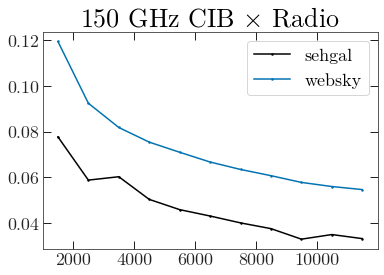

In [67]:
bx, by = bin_ps(ps3s)
plt.plot(bx, by, label='sehgal')
bx, by = bin_ps(ps3)
plt.plot(bx, by, label='websky')
# plt.yscale('log')
plt.legend()
plt.title(r'150 GHz CIB $\times$ Radio')

Text(0.5, 1.0, '150 GHz Radio $\\times$ Radio')

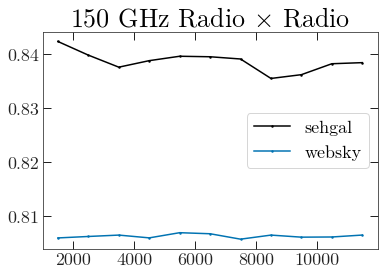

In [66]:
bx, by = bin_ps(hp.anafast(clip_map(sehgal_maps[2]), iter=0))
plt.plot(bx, by, label='sehgal')
bx, by = bin_ps(hp.anafast(clip_map(radio_maps[2]), iter=0))
plt.plot(bx, by, label='websky')
# plt.yscale('log')
plt.legend()
plt.title(r'150 GHz Radio $\times$ Radio')

Text(0.5, 1.0, '150 GHz CIB $\\times$ CIB')

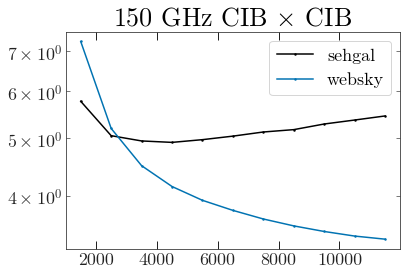

In [70]:
bx, by = bin_ps(hp.anafast(sehgal_cib_150, iter=0))
plt.plot(bx, by, label='sehgal')
bx, by = bin_ps(hp.anafast(cib_map_150, iter=0))
plt.plot(bx, by, label='websky')
plt.yscale('log')
plt.legend()
plt.title(r'150 GHz CIB $\times$ CIB')

Text(0.5, 0, '$\\log_{10}$ pixel flux in Jy/sr (150 GHz)')

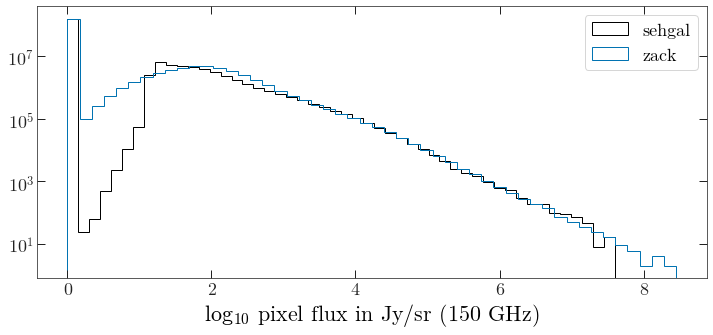

In [19]:
plt.figure(figsize=(12, 5))
plt.hist( np.log10(sehgal_maps[2]+1), histtype="step", label="sehgal", bins=50)
plt.hist( np.log10(maps[2]+1), histtype="step", label="zack", bins=50)
plt.yscale("log")

plt.legend()
plt.xlabel(r"$\log_{10}$ pixel flux in Jy/sr (150 GHz)")

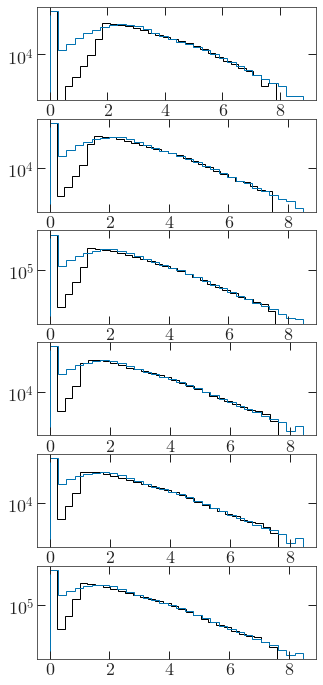

In [20]:
fig, axes = plt.subplots(len(freq_str),1,figsize=(5,12))
for i in range(len(freq_str)):
    
    axes[i].hist( np.log10(sehgal_maps[i] + 1e0), bins=30, histtype="step")
    axes[i].hist( np.log10(maps[i] + 1e0), bins=30, histtype="step")

    axes[i].set_yscale("log")

In [21]:
%time ps_auto = [hp.anafast(clip_map(m1), iter=0) for m1 in maps]

CPU times: user 44min 20s, sys: 22.6 s, total: 44min 42s
Wall time: 1min 13s


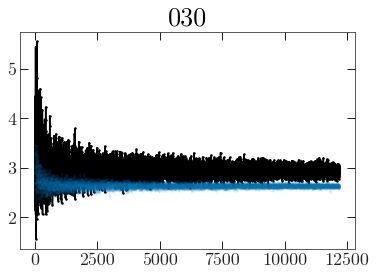

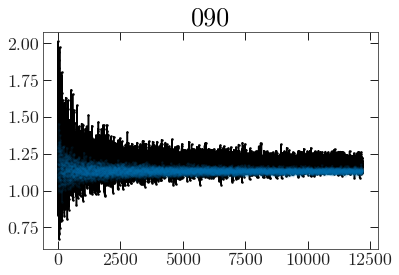

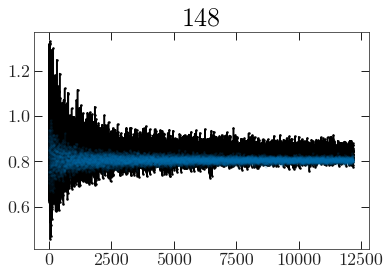

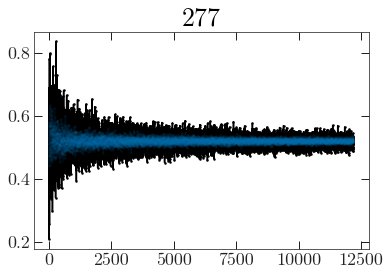

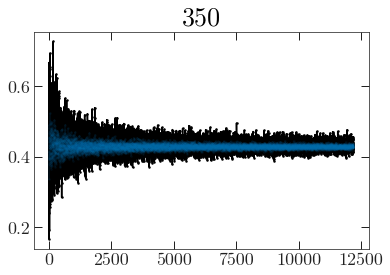

In [22]:
for i in range(len(ps_auto)):
    plt.figure()
    plt.title(freq_str[i])
    plt.plot(sehgal_ps_autos[i][100:])
    plt.plot(ps_auto[i][100:], alpha=0.1)

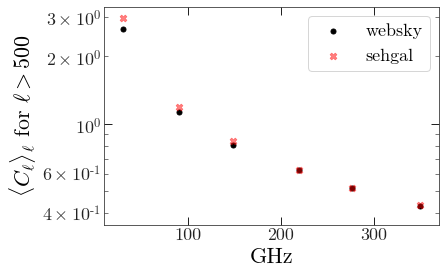

In [23]:
plt.scatter( freqs, [np.mean(ps[500:]) for ps in ps_auto], label='websky' )
plt.scatter( freqs, [np.mean(ps[500:]) for ps in sehgal_ps_autos], marker='X', label='sehgal', lw=0.5, s=50, color='r', alpha=0.5 )

plt.legend()
plt.xlabel('GHz')
plt.ylabel(r'$\langle C_{\ell} \rangle_{\ell}$ for $\ell > 500$')
plt.yscale('log')

In [24]:
np.array([np.mean(ps[500:]) for ps in ps_auto]) / np.array([np.mean(ps[500:]) for ps in sehgal_ps_autos])

array([0.89321262, 0.95591064, 0.96116466, 1.00416437, 1.00319534,
       0.98995391])